# driftax — Conditional inverse problem on a ring (bimodal posterior)

We train a conditional generator **x ~ qθ(x | y)** where:
- **x** is a 2D point on a noisy ring
- **y** is a 1D measurement: the x-coordinate (with heteroscedastic noise)

Conditioning on y yields a **bimodal** posterior (upper/lower arc).

This notebook:
1) plots the training dataset (x, y)
2) trains DiT1D (sequence length 2) with drifting loss
3) visualizes conditional samples for a few y values


In [2]:
import os, sys

# Driftax notebook backend policy:
# - macOS: FORCE CPU (avoid Metal instability)
# - other OS: let JAX auto-select (GPU if available; else CPU)
#
# NOTE: must run BEFORE importing jax.
for k in ("JAX_PLATFORMS", "JAX_PLATFORM_NAME"):
    os.environ.pop(k, None)

if sys.platform == "darwin":
    os.environ["JAX_PLATFORMS"] = "cpu"


In [4]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import optax

from driftax.datasets import inverse_ring_toy
from driftax.models import DiT1D, DiT1DConfig
from driftax.models import CondMLP
from driftax.drift import drifting_loss_features

print("JAX devices:", jax.devices())


JAX devices: [CpuDevice(id=0)]


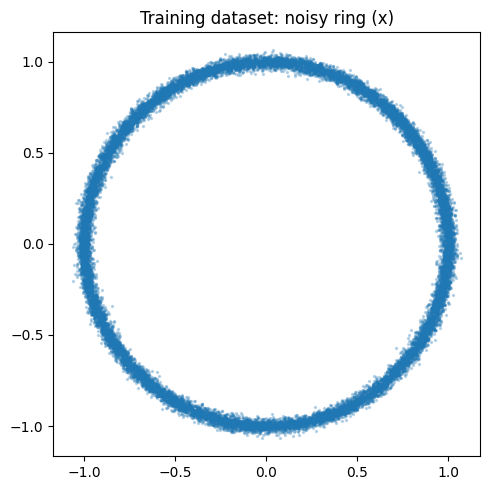

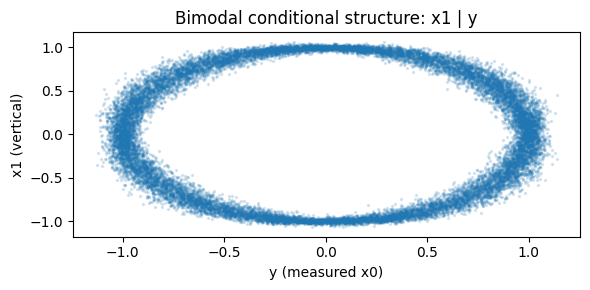

In [5]:
# Plot dataset snapshot
key = jax.random.PRNGKey(0)
x, y = inverse_ring_toy(key, 20000)
x = np.array(x)
y = np.array(y).squeeze(-1)

plt.figure(figsize=(5,5))
plt.scatter(x[:,0], x[:,1], s=2, alpha=0.25)
plt.axis("equal")
plt.title("Training dataset: noisy ring (x)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.scatter(y, x[:,1], s=2, alpha=0.15)
plt.xlabel("y (measured x0)")
plt.ylabel("x1 (vertical)")
plt.title("Bimodal conditional structure: x1 | y")
plt.tight_layout()
plt.show()


step    1 loss=2.000e+00 (ema 2.000e+00)  loss_rawV=7.212e-02 (ema 7.212e-02)  |x0-y|=1.170e+00 (ema 1.170e+00)  |r-1|=6.461e-01 (ema 6.461e-01)


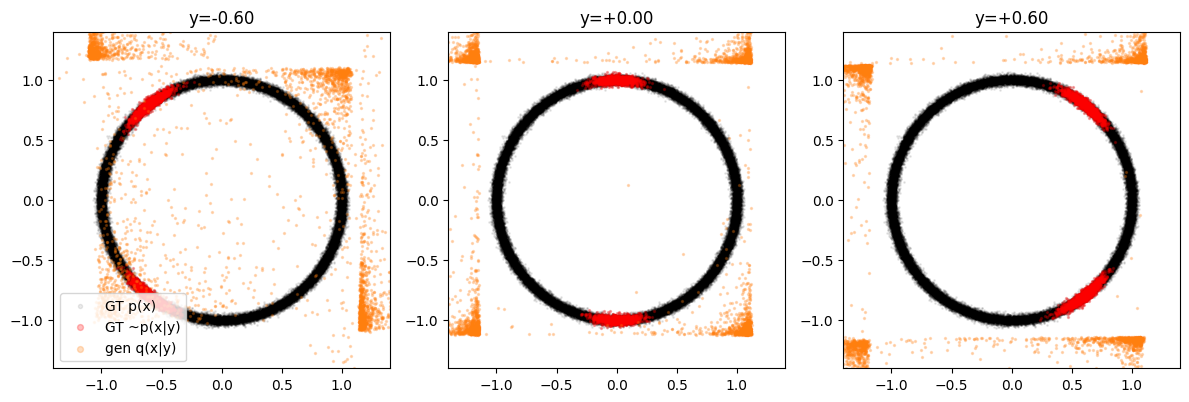

step  500 loss=2.000e+00 (ema 2.000e+00)  loss_rawV=6.786e-03 (ema 9.215e-03)  |x0-y|=2.012e-01 (ema 2.425e-01)  |r-1|=7.676e-02 (ema 9.020e-02)


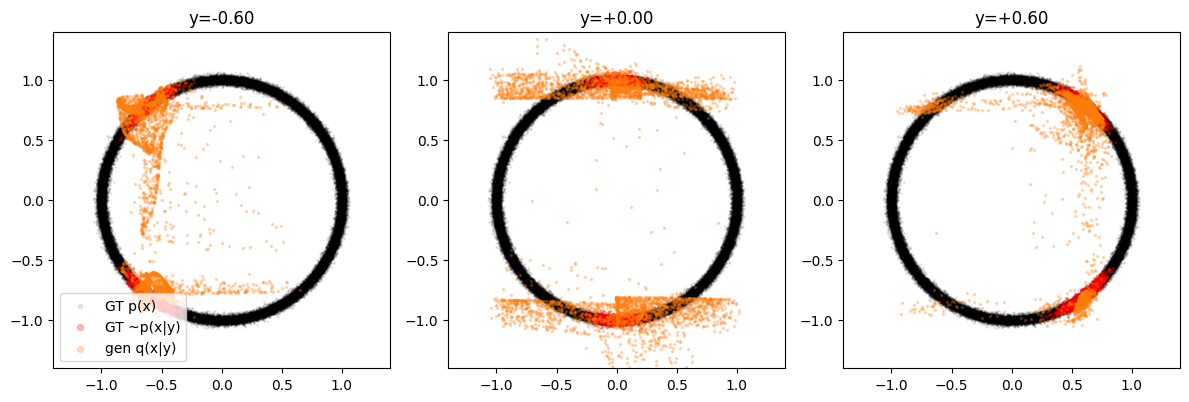

step 1000 loss=2.000e+00 (ema 2.000e+00)  loss_rawV=4.344e-04 (ema 8.446e-04)  |x0-y|=1.005e-01 (ema 1.019e-01)  |r-1|=3.899e-02 (ema 4.059e-02)


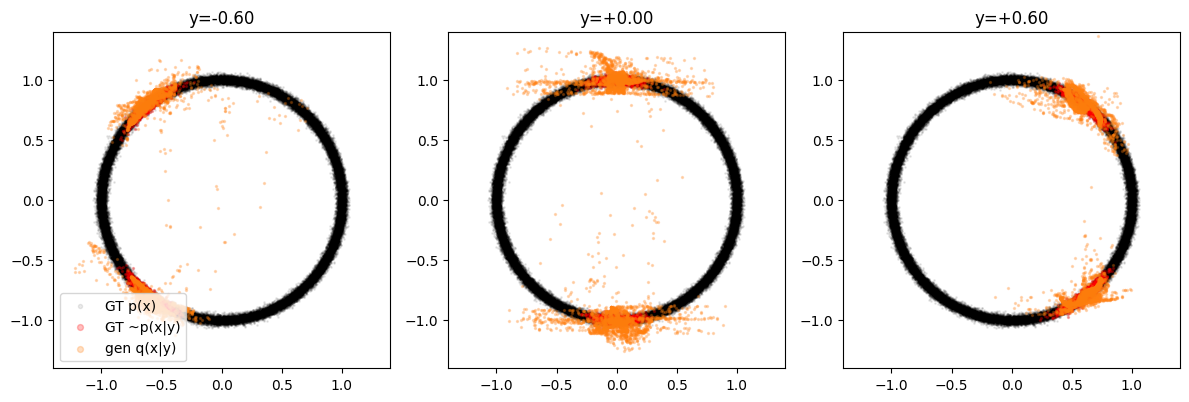

step 1500 loss=2.000e+00 (ema 2.000e+00)  loss_rawV=3.113e-04 (ema 5.226e-04)  |x0-y|=1.035e-01 (ema 1.066e-01)  |r-1|=4.333e-02 (ema 4.753e-02)


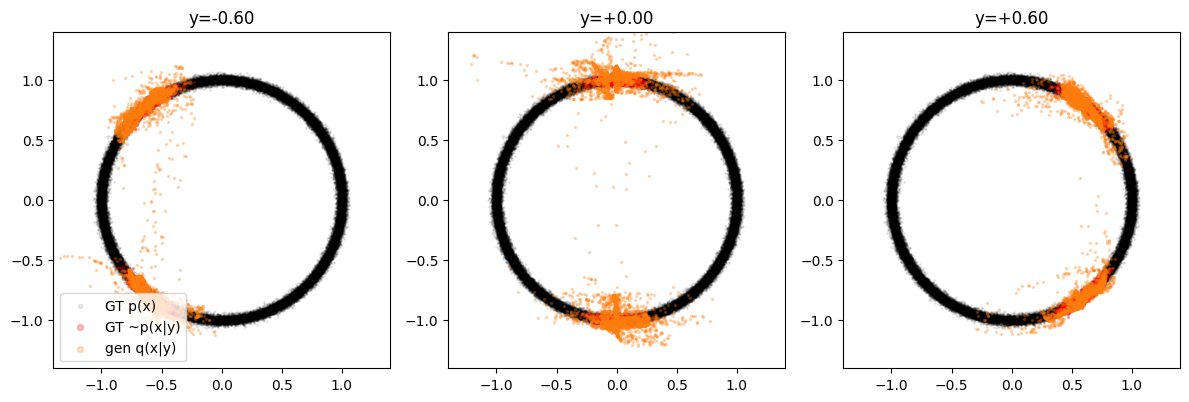

step 2000 loss=2.000e+00 (ema 2.000e+00)  loss_rawV=2.925e-04 (ema 4.272e-04)  |x0-y|=1.108e-01 (ema 1.114e-01)  |r-1|=4.781e-02 (ema 4.974e-02)


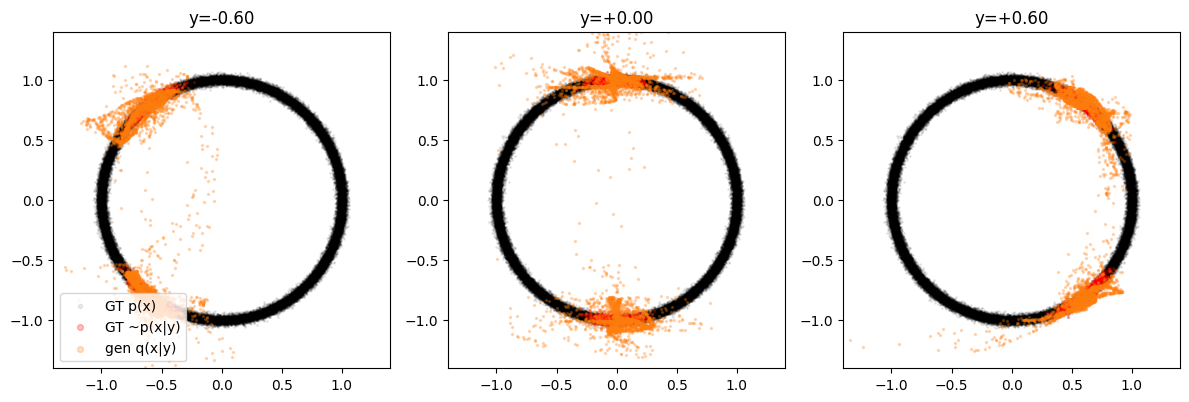

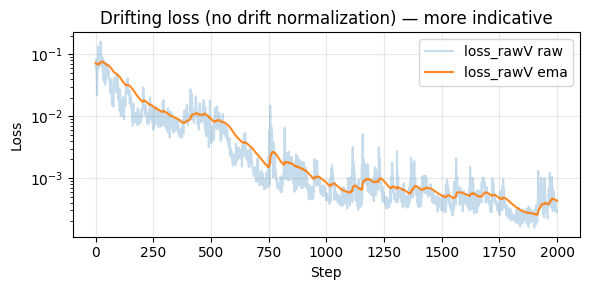

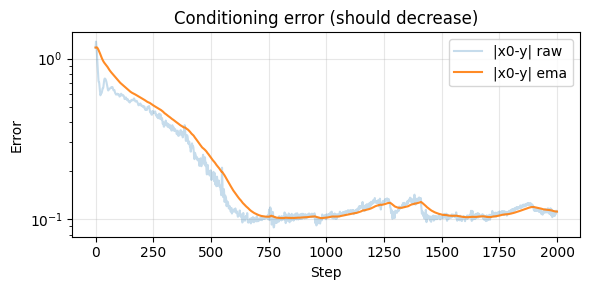

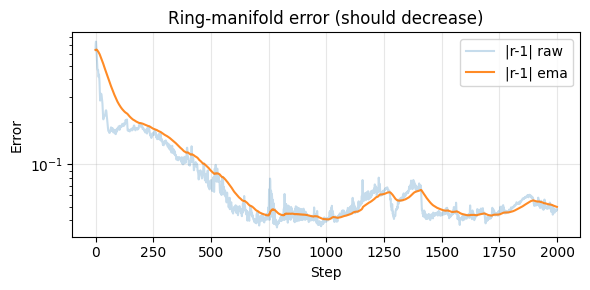

In [ ]:
# Train DiT1D on ring conditional 
cfg = DiT1DConfig(length=2, patch=1, dim=256, depth=6, heads=4, cond_dim=256, drop=0.0)
model = DiT1D(cfg)
cond_net = CondMLP(in_dim=1, out_dim=cfg.cond_dim, hidden=256)


batch = 512
POOL = 4096
steps = 2000
plot_every = 500

temps_x = (0.05,)     
TEMP_Y = 0.05
BETA_Y = 3.0

lr = 1e-4
CLIP_NORM = 1.0

# plotting
Y0_LIST = (-0.6, 0.0, 0.6)
N_GT_PLOT  = 80000
N_GEN_PLOT = 4000
SLICE_TOL  = 0.05


key = jax.random.PRNGKey(1)
key, k1, k2 = jax.random.split(key, 3)

dummy_noise = jnp.zeros((1, 2), dtype=jnp.float32)
dummy_y = jnp.zeros((1, 1), dtype=jnp.float32)

cond_params  = cond_net.init(k1, dummy_y)
cond0 = cond_net.apply(cond_params, dummy_y)
model_params = model.init(k2, dummy_noise, cond0, train=True)

params = {"cond": cond_params, "model": model_params}

opt = optax.chain(
    optax.clip_by_global_norm(CLIP_NORM),
    optax.adamw(lr, weight_decay=1e-4),
)
opt_state = opt.init(params)


def _cdist_l2(a, b):
    a2 = jnp.sum(a * a, axis=1, keepdims=True)
    b2 = jnp.sum(b * b, axis=1, keepdims=True).T
    return jnp.sqrt(jnp.maximum(a2 + b2 - 2.0 * (a @ b.T), 0.0) + 1e-12)

def _softmax2d_rowcol(logits):
    K = jnp.exp(logits - jnp.max(logits, axis=1, keepdims=True))
    row = jnp.sum(K, axis=1, keepdims=True)
    col = jnp.sum(K, axis=0, keepdims=True)
    norm = jnp.sqrt(jnp.maximum(row * col, 1e-12))
    return K / norm

def _normalize_features(x, targets):
    scale = jnp.sqrt(jnp.mean(targets * targets) + 1e-12)
    scale = jax.lax.stop_gradient(scale)
    return x / scale, targets / scale

def _normalize_drift(V):
    s = jnp.sqrt(jnp.mean(V * V) + 1e-12)
    return V / s

def compute_V_conditional(x, y, pos_x, pos_y, neg_x, neg_y, temp_x, temp_y, beta_y=1.0):
    dx_pos = _cdist_l2(x, pos_x)
    dx_neg = _cdist_l2(x, neg_x)
    dy_pos = _cdist_l2(y, pos_y)
    dy_neg = _cdist_l2(y, neg_y)

    # mask self when neg == x
    n = x.shape[0]
    if neg_x.shape[0] >= n:
        big = jnp.eye(n, dtype=dx_neg.dtype) * 1e6
        dx_neg = dx_neg.at[:, :n].add(big)
        dy_neg = dy_neg.at[:, :n].add(big)

    logits_pos = -(dx_pos / temp_x + beta_y * (dy_pos / temp_y))
    logits_neg = -(dx_neg / temp_x + beta_y * (dy_neg / temp_y))
    logits = jnp.concatenate([logits_pos, logits_neg], axis=1)

    A = _softmax2d_rowcol(logits)
    P = pos_x.shape[0]
    A_pos = A[:, :P]
    A_neg = A[:, P:]

    W_pos = A_pos * jnp.sum(A_neg, axis=1, keepdims=True)
    W_neg = A_neg * jnp.sum(A_pos, axis=1, keepdims=True)

    return (W_pos @ pos_x) - (W_neg @ neg_x)

def drifting_loss_conditional_features(
    x_feat, y, pos_feat, pos_y,
    temps_x=(0.05,), temp_y=0.05, beta_y=3.0,
    feature_normalize=True, drift_normalize=True,
):
    neg_feat = x_feat
    neg_y = y

    if feature_normalize:
        targets = jnp.concatenate([pos_feat, neg_feat], axis=0)
        x_n, targets_n = _normalize_features(x_feat, targets)
        pos_n = targets_n[:pos_feat.shape[0]]
        neg_n = targets_n[pos_feat.shape[0]:]
    else:
        x_n, pos_n, neg_n = x_feat, pos_feat, neg_feat

    Vs = []
    for Tx in temps_x:
        Vs.append(compute_V_conditional(
            x_n, y,
            pos_n, pos_y,
            neg_n, neg_y,
            temp_x=float(Tx),
            temp_y=float(temp_y),
            beta_y=float(beta_y),
        ))
    V = sum(Vs) / float(len(Vs))

    if drift_normalize:
        V = _normalize_drift(V)

    target = jax.lax.stop_gradient(x_n + V)
    return jnp.mean(jnp.sum((x_n - target) ** 2, axis=-1))


def loss_and_metrics(params, key):
    key, kpool, ky, kz = jax.random.split(key, 4)

    # paired positives pool
    pos_x, pos_y = inverse_ring_toy(kpool, POOL)  # [POOL,2], [POOL,1]

    # sample y inputs uniformly (inverse-problem conditioning inputs)
    y_in = jax.random.uniform(ky, (batch, 1), minval=-1.0, maxval=1.0, dtype=jnp.float32)
    c = cond_net.apply(params["cond"], y_in)

    # generate x|y
    z = jax.random.normal(kz, (batch, 2), dtype=jnp.float32)
    x_gen = model.apply(params["model"], z, c, train=True)

    # training loss (normalized drift)
    loss = drifting_loss_conditional_features(
        x_feat=x_gen, y=y_in,
        pos_feat=pos_x, pos_y=pos_y,
        temps_x=temps_x,
        temp_y=TEMP_Y,
        beta_y=BETA_Y,
        feature_normalize=True,
        drift_normalize=True,
    )

    # logging loss without drift normalization 
    loss_rawV = drifting_loss_conditional_features(
        x_feat=x_gen, y=y_in,
        pos_feat=pos_x, pos_y=pos_y,
        temps_x=temps_x,
        temp_y=TEMP_Y,
        beta_y=BETA_Y,
        feature_normalize=True,
        drift_normalize=False,
    )

    # metrics that should trend
    cond_err = jnp.mean(jnp.abs(x_gen[:, 0] - y_in[:, 0]))  # enforce x0 ~ y
    r = jnp.sqrt(jnp.sum(x_gen * x_gen, axis=1) + 1e-12)
    ring_err = jnp.mean(jnp.abs(r - 1.0))                   # enforce radius ~ 1

    return loss, (loss_rawV, cond_err, ring_err)

@jax.jit
def step_fn(params, opt_state, key):
    (loss, (loss_rawV, cond_err, ring_err)), grads = jax.value_and_grad(
        lambda p: loss_and_metrics(p, key), has_aux=True
    )(params)
    updates, opt_state2 = opt.update(grads, opt_state, params)
    params2 = optax.apply_updates(params, updates)
    return params2, opt_state2, key, loss, loss_rawV, cond_err, ring_err


def conditional_plot(params, y0_list=Y0_LIST, n_gen=N_GEN_PLOT, tol=SLICE_TOL):
    k = jax.random.PRNGKey(123)
    x_true, y_true = inverse_ring_toy(k, N_GT_PLOT)
    xt = np.array(x_true)
    yt = np.array(y_true).squeeze(-1)

    fig, axes = plt.subplots(1, len(y0_list), figsize=(4 * len(y0_list), 4), sharex=False, sharey=False)
    if len(y0_list) == 1:
        axes = [axes]

    for i, (ax, y0) in enumerate(zip(axes, y0_list)):
        ax.scatter(xt[:, 0], xt[:, 1], s=1, alpha=0.08, c="black", label="GT p(x)" if i == 0 else None)

        m = np.abs(yt - y0) < tol
        ax.scatter(xt[m, 0], xt[m, 1], s=2, alpha=0.25, c="red", label="GT ~p(x|y)" if i == 0 else None)

        y_in = jnp.full((n_gen, 1), float(y0), dtype=jnp.float32)
        c = cond_net.apply(params["cond"], y_in)
        kgen = jax.random.PRNGKey(1000 + i)
        z = jax.random.normal(kgen, (n_gen, 2), dtype=jnp.float32)
        xg = np.array(model.apply(params["model"], z, c, train=False))

        ax.scatter(xg[:, 0], xg[:, 1], s=2, alpha=0.25, c="tab:orange", label="gen q(x|y)" if i == 0 else None)

        ax.set_title(f"y={y0:+.2f}")
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim(-1.4, 1.4)
        ax.set_ylim(-1.4, 1.4)

    axes[0].legend(loc="lower left", markerscale=3)
    fig.tight_layout()
    plt.show()


loss_hist, ema_loss_hist = [], []
raw_hist,  ema_raw_hist  = [], []
cond_hist, ema_cond_hist = [], []
ring_hist, ema_ring_hist = [], []

ema_loss = ema_raw = ema_cond = ema_ring = None

for s in range(1, steps + 1):
    params, opt_state, key, loss, loss_rawV, cond_err, ring_err = step_fn(params, opt_state, key)

    lv = float(loss)
    rv = float(loss_rawV)
    cv = float(cond_err)
    rg = float(ring_err)

    loss_hist.append(lv); raw_hist.append(rv); cond_hist.append(cv); ring_hist.append(rg)

    ema_loss = lv if ema_loss is None else 0.98 * ema_loss + 0.02 * lv
    ema_raw  = rv if ema_raw  is None else 0.98 * ema_raw  + 0.02 * rv
    ema_cond = cv if ema_cond is None else 0.98 * ema_cond + 0.02 * cv
    ema_ring = rg if ema_ring is None else 0.98 * ema_ring + 0.02 * rg

    ema_loss_hist.append(ema_loss)
    ema_raw_hist.append(ema_raw)
    ema_cond_hist.append(ema_cond)
    ema_ring_hist.append(ema_ring)

    if s == 1 or (plot_every and s % plot_every == 0) or s == steps:
        print(
            f"step {s:4d} "
            f"loss={lv:.3e} (ema {ema_loss:.3e})  "
            f"loss_rawV={rv:.3e} (ema {ema_raw:.3e})  "
            f"|x0-y|={cv:.3e} (ema {ema_cond:.3e})  "
            f"|r-1|={rg:.3e} (ema {ema_ring:.3e})"
        )
        conditional_plot(params)


loss_hist = np.asarray(loss_hist, dtype=np.float32)
raw_hist = np.asarray(raw_hist,  dtype=np.float32)
cond_hist = np.asarray(cond_hist, dtype=np.float32)
ring_hist = np.asarray(ring_hist, dtype=np.float32)

ema_loss_hist = np.asarray(ema_loss_hist, dtype=np.float32)
ema_raw_hist  = np.asarray(ema_raw_hist,  dtype=np.float32)
ema_cond_hist = np.asarray(ema_cond_hist, dtype=np.float32)
ema_ring_hist = np.asarray(ema_ring_hist, dtype=np.float32)



plt.figure(figsize=(6,3))
plt.plot(raw_hist, alpha=0.25, label="loss_rawV raw")
plt.plot(ema_raw_hist, alpha=0.9, label="loss_rawV ema")
plt.yscale("log"); plt.grid(True, alpha=0.3)
plt.xlabel("Step"); plt.ylabel("Loss")
plt.title("Drifting loss (no drift normalization) — more indicative")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(cond_hist, alpha=0.25, label="|x0-y| raw")
plt.plot(ema_cond_hist, alpha=0.9, label="|x0-y| ema")
plt.yscale("log"); plt.grid(True, alpha=0.3)
plt.xlabel("Step"); plt.ylabel("Error")
plt.title("Conditioning error (should decrease)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3))
plt.plot(ring_hist, alpha=0.25, label="|r-1| raw")
plt.plot(ema_ring_hist, alpha=0.9, label="|r-1| ema")
plt.yscale("log"); plt.grid(True, alpha=0.3)
plt.xlabel("Step"); plt.ylabel("Error")
plt.title("Ring-manifold error (should decrease)")
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
from driftax.models import MDNConfig, MDN1D, mdn_nll_1d, mdn_mixture_pdf_1d

# MDN
key_mdn = jax.random.PRNGKey(0)
N_train = 60000
N_val   = 10000

k1, k2 = jax.random.split(key_mdn, 2)
x_all, y_all = inverse_ring_toy(k1, N_train + N_val)   # x:[N,2], y:[N,1]
x1_all = x_all[:, 1:2]                                 # target is x1

y_train = y_all[:N_train]
x1_train = x1_all[:N_train]
y_val = y_all[N_train:]
x1_val = x1_all[N_train:]

cfg_mdn = MDNConfig(num_mixtures=8, hidden=128, depth=3, min_scale=1e-3)
mdn = MDN1D(cfg_mdn)

mdn_params = mdn.init(k2, jnp.zeros((1,1), dtype=jnp.float32))

opt_mdn = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adamw(1e-3, weight_decay=1e-4),
)
mdn_opt_state = opt_mdn.init(mdn_params)

batch_mdn = 512
steps_mdn = 3000
print_every = 300

rng = np.random.default_rng(0)

@jax.jit
def mdn_step(params, opt_state, yb, xb):
    loss, grads = jax.value_and_grad(lambda p: mdn_nll_1d(p, mdn, yb, xb))(params)
    updates, opt_state2 = opt_mdn.update(grads, opt_state, params)
    params2 = optax.apply_updates(params, updates)
    return params2, opt_state2, loss

ema = None
for s in range(1, steps_mdn + 1):
    idx = rng.integers(0, N_train, size=(batch_mdn,))
    yb = y_train[idx]
    xb = x1_train[idx]

    mdn_params, mdn_opt_state, loss = mdn_step(mdn_params, mdn_opt_state, yb, xb)
    lv = float(loss)
    ema = lv if ema is None else 0.99 * ema + 0.01 * lv

    if s == 1 or (s % print_every == 0) or (s == steps_mdn):
        vloss = float(mdn_nll_1d(mdn_params, mdn, y_val, x1_val))
        print(f"[MDN] step {s:4d} nll={lv:.3f} ema={ema:.3f} val_nll={vloss:.3f}")

[MDN] step    1 nll=1.066 ema=1.066 val_nll=1.064
[MDN] step  300 nll=-0.183 ema=0.015 val_nll=-0.206
[MDN] step  600 nll=-0.356 ema=-0.281 val_nll=-0.348
[MDN] step  900 nll=-0.408 ema=-0.382 val_nll=-0.332
[MDN] step 1200 nll=-0.475 ema=-0.429 val_nll=-0.459
[MDN] step 1500 nll=-0.536 ema=-0.477 val_nll=-0.489
[MDN] step 1800 nll=-0.530 ema=-0.484 val_nll=-0.468
[MDN] step 2100 nll=-0.474 ema=-0.497 val_nll=-0.500
[MDN] step 2400 nll=-0.558 ema=-0.503 val_nll=-0.495
[MDN] step 2700 nll=-0.438 ema=-0.497 val_nll=-0.516
[MDN] step 3000 nll=-0.466 ema=-0.496 val_nll=-0.490


In [ ]:
from driftax.models import CFMConfig, CondVelocityMLP, cfm_loss, cfm_sample

# Conditional Flow Matching
key_cfm = jax.random.PRNGKey(0)
N_train_cfm = 80000
N_val_cfm   = 20000

k1, k2 = jax.random.split(key_cfm, 2)
x_all, y_all = inverse_ring_toy(k1, N_train_cfm + N_val_cfm)

x_train = x_all[:N_train_cfm]
y_train = y_all[:N_train_cfm]
x_val = x_all[N_train_cfm:]
y_val = y_all[N_train_cfm:]

cfg_cfm = CFMConfig(hidden=256, depth=4, sigma=0.0, steps=60)
cfm = CondVelocityMLP(cfg_cfm)

cfm_params = cfm.init(
    k2,
    jnp.zeros((1,1), dtype=jnp.float32),
    jnp.zeros((1,2), dtype=jnp.float32),
    jnp.zeros((1,1), dtype=jnp.float32),
)

opt_cfm = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adamw(2e-4, weight_decay=1e-4),
)
cfm_opt_state = opt_cfm.init(cfm_params)

batch_cfm = 512
steps_cfm = 4000
print_every = 400
rng = np.random.default_rng(0)

@jax.jit
def cfm_step(params, opt_state, key, xb, yb):
    loss, grads = jax.value_and_grad(lambda p: cfm_loss(p, cfm, key, xb, yb, sigma=cfg_cfm.sigma))(params)
    updates, opt_state2 = opt_cfm.update(grads, opt_state, params)
    params2 = optax.apply_updates(params, updates)
    return params2, opt_state2, loss

ema = None
key_loop = jax.random.PRNGKey(123)

for s in range(1, steps_cfm + 1):
    idx = rng.integers(0, N_train_cfm, size=(batch_cfm,))
    xb = x_train[idx]
    yb = y_train[idx]

    key_loop, kstep = jax.random.split(key_loop)
    cfm_params, cfm_opt_state, loss = cfm_step(cfm_params, cfm_opt_state, kstep, xb, yb)

    lv = float(loss)
    ema = lv if ema is None else 0.99 * ema + 0.01 * lv

    if s == 1 or (s % print_every == 0) or (s == steps_cfm):
        key_loop, kval = jax.random.split(key_loop)
        vloss = float(cfm_loss(cfm_params, cfm, kval, x_val[:4096], y_val[:4096], sigma=cfg_cfm.sigma))
        print(f"[CFM] step {s:4d} mse={lv:.4f} ema={ema:.4f} val_mse={vloss:.4f}")

[CFM] step    1 mse=3.0091 ema=3.0091 val_mse=2.9146
[CFM] step  400 mse=0.9798 ema=1.0412 val_mse=0.9469
[CFM] step  800 mse=0.7875 ema=0.9554 val_mse=0.8884
[CFM] step 1200 mse=0.8989 ema=0.9309 val_mse=0.9249
[CFM] step 1600 mse=0.8780 ema=0.9246 val_mse=0.9040
[CFM] step 2000 mse=0.8662 ema=0.9204 val_mse=0.9166
[CFM] step 2400 mse=0.8401 ema=0.9210 val_mse=0.8838
[CFM] step 2800 mse=0.8536 ema=0.9021 val_mse=0.8685
[CFM] step 3200 mse=0.8853 ema=0.9003 val_mse=0.9130
[CFM] step 3600 mse=0.9656 ema=0.9052 val_mse=0.9145
[CFM] step 4000 mse=0.7513 ema=0.9009 val_mse=0.8351


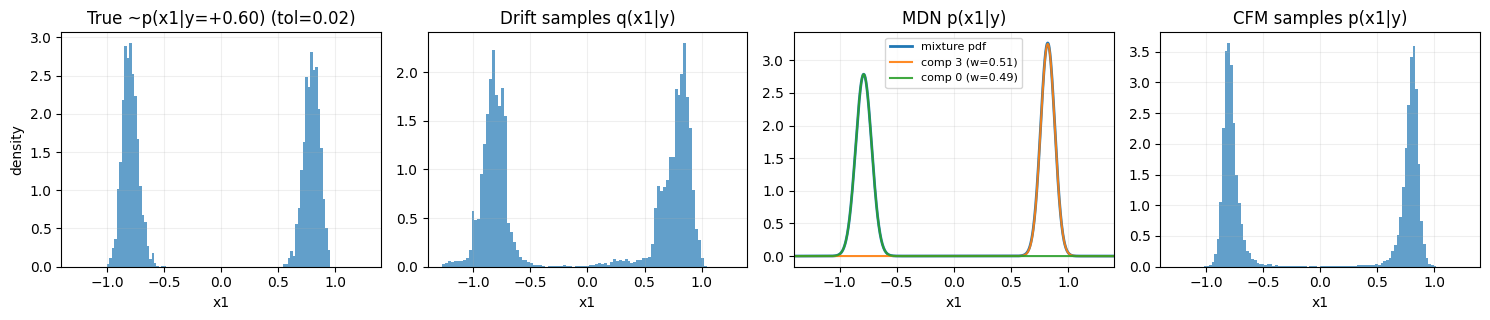

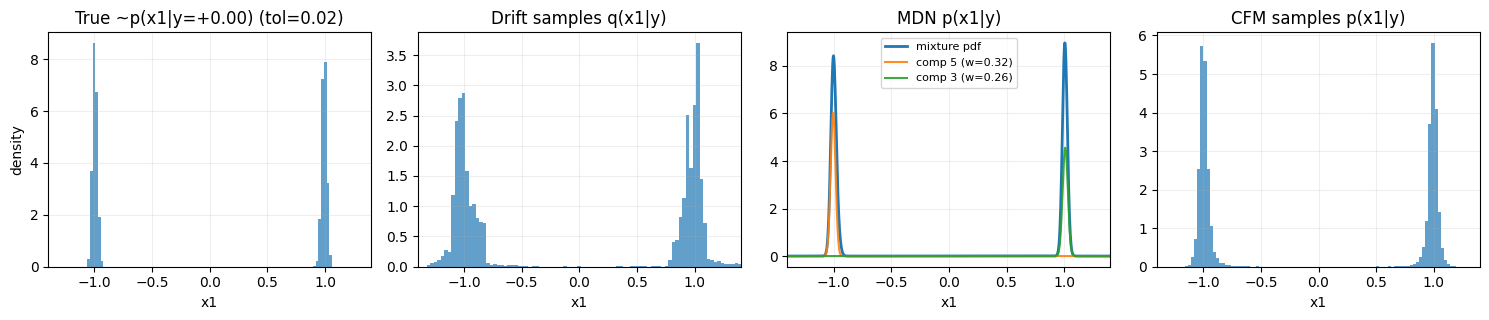

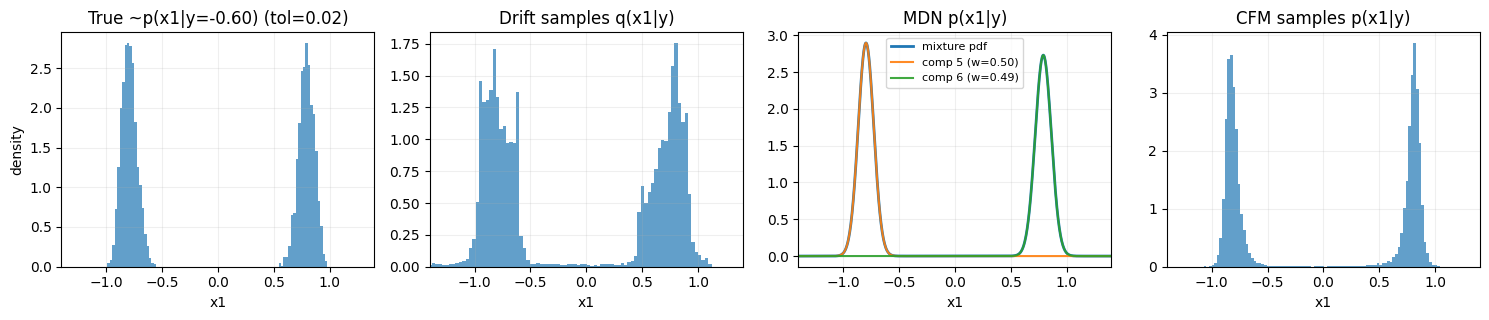

In [ ]:
def sample_drift_x1(params_drift, y0, n=20000, seed=0):
    key = jax.random.PRNGKey(seed)
    y_in = jnp.full((n, 1), float(y0), dtype=jnp.float32)
    c = cond_net.apply(params_drift["cond"], y_in)
    z = jax.random.normal(key, (n, 2), dtype=jnp.float32)
    xg = model.apply(params_drift["model"], z, c, train=False)
    return np.array(xg[:, 1])  # x1

def sample_cfm_x1(y0, n=20000, seed=0):
    key = jax.random.PRNGKey(seed)
    y_in = jnp.full((n, 1), float(y0), dtype=jnp.float32)
    xf = cfm_sample(cfm_params, cfm, key, y_in, steps=cfg_cfm.steps)  # [N,2]
    return np.array(xf[:, 1])

def sample_true_x1(y0, n=200000, tol=0.02, seed=123):
    key = jax.random.PRNGKey(seed)
    x, y = inverse_ring_toy(key, n)
    x1 = np.array(x[:, 1])
    yy = np.array(y[:, 0])
    m = np.abs(yy - y0) < tol
    return x1[m]

def _normal_pdf(grid, mu, sigma):
    z = (grid - mu) / sigma
    return (1.0 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-0.5 * z*z)

def plot_conditional_1d(y0=0.6, tol=0.02):
    x1_true = sample_true_x1(y0, n=200000, tol=tol, seed=123)
    x1_drift = sample_drift_x1(params, y0, n=20000, seed=0)
    x1_cfm = sample_cfm_x1(y0, n=20000, seed=0)

    # MDN mixture pdf (+ show two dominant components)
    y_in = jnp.array([[float(y0)]], dtype=jnp.float32)
    logits, means, scales = mdn.apply(mdn_params, y_in)
    logits = np.array(logits[0]); means = np.array(means[0]); scales = np.array(scales[0])

    pi = np.exp(logits - np.max(logits))
    pi = pi / np.sum(pi)

    grid = np.linspace(-1.4, 1.4, 800)
    pdf_mix = np.array(mdn_mixture_pdf_1d(jnp.array(logits), jnp.array(means), jnp.array(scales), jnp.array(grid)))

    top2 = np.argsort(-pi)[:2]
    comp1 = _normal_pdf(grid, means[top2[0]], scales[top2[0]])
    comp2 = _normal_pdf(grid, means[top2[1]], scales[top2[1]])

    fig, axes = plt.subplots(1, 4, figsize=(15, 3.3), sharey=False)

    axes[0].hist(x1_true, bins=90, density=True, alpha=0.7)
    axes[0].set_title(f"True ~p(x1|y={y0:+.2f}) (tol={tol})")
    axes[0].set_xlabel("x1"); axes[0].set_ylabel("density")

    axes[1].hist(x1_drift, bins=90, density=True, alpha=0.7)
    axes[1].set_title("Drift samples q(x1|y)")
    axes[1].set_xlabel("x1")

    axes[2].plot(grid, pdf_mix, linewidth=2, label="mixture pdf")
    axes[2].plot(grid, pi[top2[0]] * comp1, linewidth=1.5, alpha=0.9, label=f"comp {top2[0]} (w={pi[top2[0]]:.2f})")
    axes[2].plot(grid, pi[top2[1]] * comp2, linewidth=1.5, alpha=0.9, label=f"comp {top2[1]} (w={pi[top2[1]]:.2f})")
    axes[2].set_title("MDN p(x1|y)")
    axes[2].set_xlabel("x1")
    axes[2].legend(fontsize=8)

    axes[3].hist(x1_cfm, bins=90, density=True, alpha=0.7)
    axes[3].set_title("CFM samples p(x1|y)")
    axes[3].set_xlabel("x1")

    for ax in axes:
        ax.set_xlim(-1.4, 1.4)
        ax.grid(True, alpha=0.2)

    plt.tight_layout()
    plt.show()

plot_conditional_1d(y0=0.6, tol=0.02)
plot_conditional_1d(y0=0.0, tol=0.02)
plot_conditional_1d(y0=-0.6, tol=0.02)